In [1]:
from datasets import load_dataset

In [10]:
name = "Skylion007/openwebtext"
dt = load_dataset(name)

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

In [11]:
dt

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8013769
    })
})

In [12]:
dt = dt["train"]
# dt = dt.remove_columns("meta")

In [5]:
from itertools import chain

def split(batch):
    result = []
    for text in batch["text"]:
        texts = text.split("\n\n")
        result.append(texts)
    result = list(chain(*result))
    return {"text": result}

In [6]:
dt = dt.map(
    split,
    batched=True,
    num_proc=30,
    desc="Dataset split",
    batch_size=1000,
)

Dataset split (num_proc=30):   0%|          | 0/8013769 [00:00<?, ? examples/s]

In [7]:
dt

Dataset({
    features: ['text'],
    num_rows: 166005717
})

In [13]:
# Filter small texts
min_symbols = 150
dt = dt.filter(lambda b: len(b["text"]) >= min_symbols, num_proc=30)

Filter (num_proc=30):   0%|          | 0/8013769 [00:00<?, ? examples/s]

In [14]:
dt

Dataset({
    features: ['text'],
    num_rows: 8013769
})

In [15]:
import nltk

# Split into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

threshold_number_of_tokens = 400

def split_and_join_into_sents(batch):
    result = []

    for text in batch["text"]:
        texts = tokenizer.tokenize(text)
        
        cur_text = ''
        for text in texts:
            if len(cur_text.split()) + len(text.split()) < threshold_number_of_tokens:
                if cur_text:
                    cur_text += ' ' + text
                else:
                    cur_text = text
            else:
                result.append(cur_text)
                cur_text = text
        if cur_text:
            result.append(cur_text)

    return {"text": result}

In [16]:
joined_dt = dt.map(
    split_and_join_into_sents,
    batched=True,
    num_proc=30,
    desc="Dataset split",
    batch_size=1000,
)

Dataset split (num_proc=30):   0%|          | 0/8013769 [00:00<?, ? examples/s]

In [17]:
joined_dt

Dataset({
    features: ['text'],
    num_rows: 20668195
})

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [19]:
sample_size = 100000
# Shuffle the dataset to ensure randomness and reproducibility
sampled_dt = joined_dt.shuffle(seed=42).select(range(sample_size))


In [20]:
from tqdm import tqdm

texts = sampled_dt["text"]

lengths = []

for i in tqdm(range(0, len(texts), 1000)):
    batch = tokenizer(texts[i:i+1000])
    batch_lengths = [len(t) for t in batch["input_ids"]]
    lengths.extend(batch_lengths)

100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [21]:
sum(lengths) / 100000 * joined_dt.num_rows

9096372928.37335

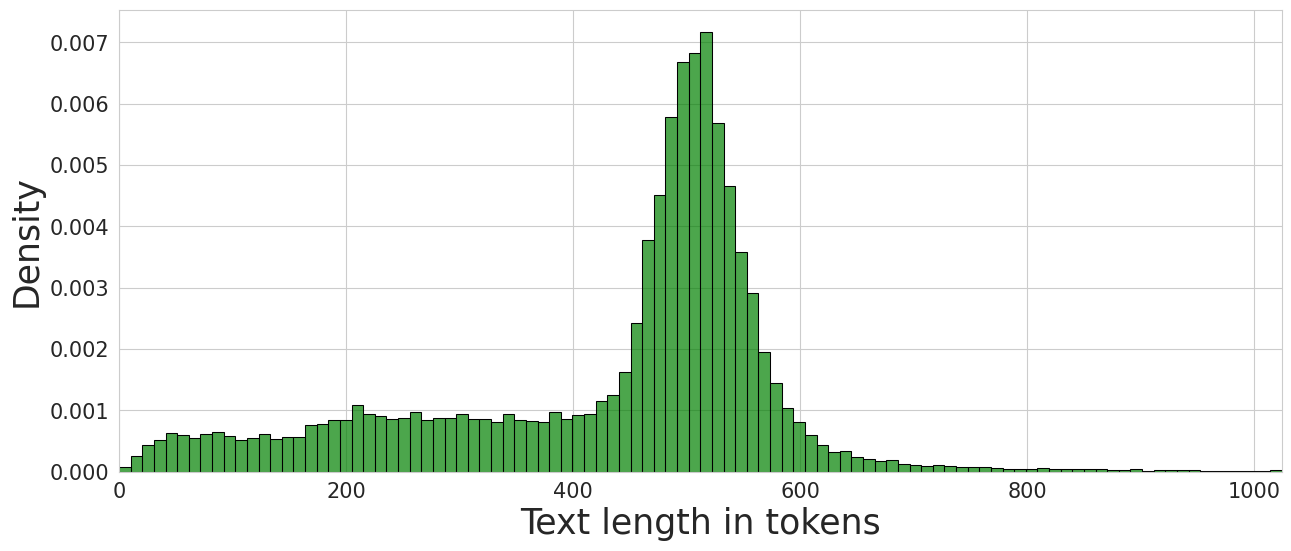

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the style for an awesome look
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

max_length = 1024

font_size = 20
num_bins = 100
bins = np.linspace(0, max_length, num_bins + 1)

# Plot histograms
sns.histplot(lengths, bins=bins, color="green", label="Wikipedia-emnlp", alpha=0.7, edgecolor="black", stat="density")

# Add title and labels with a creative touch
# Title with colored text
# plt.title("Positivity vs Negativity: A Histogram of Contrasts", fontsize=font_size + 10, fontweight="bold", pad=15)

plt.xlabel("Text length in tokens", fontsize=font_size + 5)
plt.ylabel("Density", fontsize=font_size + 5)

# Set x-axis limits between 0 and 1000
plt.xlim(0, max_length)

# Adjust tick sizes
plt.xticks(fontsize=font_size - 5)
plt.yticks(fontsize=font_size - 5)

# Add legend
# legend = plt.legend(frameon=True, loc="upper right", prop={'weight': 'bold', 'size': font_size}, edgecolor="black")  # Positioned at the upper right with bold text

# Get legend position
# legend_bbox = legend.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

# Save as PDF
plt.savefig(f"openwebtext-512-histogram.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [25]:
joined_dt = joined_dt.rename_column("text", "text_trg")

In [26]:
# Shuffle and split the dataset
test_size = 50000
train_test_split = joined_dt.train_test_split(test_size=test_size, shuffle=True, seed=42)

In [ ]:
train_test_split.save_to_disk("../data/openwebtext-512", max_shard_size="2GB")

Saving the dataset (0/20 shards):   0%|          | 0/20618195 [00:00<?, ? examples/s]